In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def show_image(img, title="Image"):
    # Convert BGR (OpenCV format) to RGB for displaying with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

path = "assets/"
template_path = f"{path}healthbar.jpg"
target_path = f"{path}minecraft.jpg"

Finding healthbar..: 100%|██████████| 100/100 [00:01<00:00, 63.27it/s]


Best match at location: (338, 630), scale: 0.9912457912457913


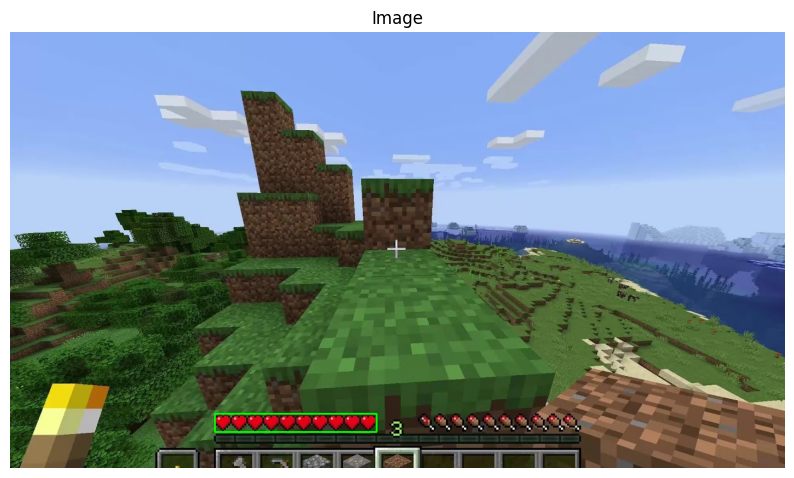

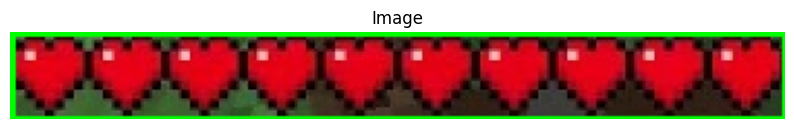

In [ ]:
def dynamic_template_matching(template_path, target_path):
    """
    Perform dynamic template matching by resizing the template image and finding the best match in the target image.

    :param template_path: Path to the template image.
    :param target_path: Path to the target image.
    :return: Best match location, scale, and matching result.
    """
    
    # Read the template and target images
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)

    # Define dynamic scales based on target dimensions
    min_scale = 0.05 * target.shape[1] / template.shape[1]
    max_scale = 0.5 * target.shape[1] / template.shape[1]
    scales = np.linspace(min_scale, max_scale, 100)

    if template is None or target is None:
        raise ValueError("Template or target image could not be loaded.")

    best_match = None
    best_value = -np.inf
    best_scale = 1.0
    best_location = None

    for scale in tqdm(scales, colour="green", desc="Finding healthbar.."):
        # Resize the template
        resized_template = cv2.resize(template, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

        # Perform template matching
        match_result = cv2.matchTemplate(target, resized_template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)

        # Update best match if current scale gives a better result
        if max_val > best_value:
            best_value = max_val
            best_match = match_result
            best_scale = scale
            best_location = max_loc

    return best_location, best_scale, best_match

location, scale, result = dynamic_template_matching(template_path, target_path)
print(f"Best match at location: {location}, scale: {scale}")

# Visualization
if location:
    target_image = cv2.imread(target_path)
    h, w = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE).shape
    h, w = int(h * scale), int(w * scale)

    # Draw rectangle on best match
    top_left = location
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(target_image, top_left, bottom_right, (0, 255, 0), 2)
    show_image(target_image)

    cropped_image = target_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    cv2.imwrite(f"{path}cropped_healthbar.jpg", cropped_image)
    show_image(cropped_image)


Matches: 10


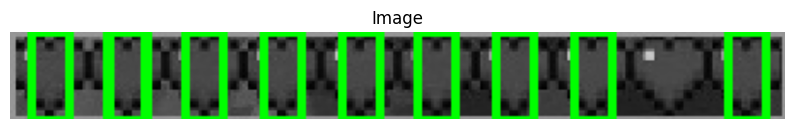

In [ ]:
import cv2
import numpy as np

# Load the target image
target = cv2.imread(f"{path}cropped_healthbar.jpg", cv2.IMREAD_GRAYSCALE)
target_height = target.shape[0]

# Function to rescale template with proportional width
def rescale_template(template, target_height):
    aspect_ratio = template.shape[1] / template.shape[0]  # width / height
    new_width = int(target_height * aspect_ratio)  # Proportional width
    return cv2.resize(template, (new_width, target_height))

# Load and rescale the full heart template
template_full = cv2.imread(f"{path}small_heart.jpg", cv2.IMREAD_GRAYSCALE)
template_full = rescale_template(template_full, target_height)

# Match templates with non-overlapping suppression
def match_full_hearts(target, template, threshold=0.8, max_matches=10):
    result = cv2.matchTemplate(target, template, cv2.TM_CCOEFF_NORMED)
    matches = []
    h, w = template.shape[:2]

    while len(matches) < max_matches:
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        if max_val < threshold:
            break  # Stop if no matches above the threshold

        matches.append((max_loc, max_val))  # Store location and confidence

        # Suppress the matched region
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(result, top_left, bottom_right, 0, -1)  # Suppress region

    # Sort matches by x-coordinate to keep them in logical order
    matches.sort(key=lambda x: x[0][0])

    print(f"Matches: {len(matches)}")
    return matches[:max_matches]

# Find exactly 10 full hearts
matches = match_full_hearts(target, template_full, threshold=0.1, max_matches=10)

# Visualize the results
output_image = cv2.cvtColor(target, cv2.COLOR_GRAY2BGR)

for loc, _ in matches:
    top_left = loc
    h, w = template_full.shape[:2]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(output_image, top_left, bottom_right, (0, 255, 0), 2)  # Green for full hearts

# Display the result
show_image(output_image)
